# Policy search
Policy search RL algorithm for playing the game of Space Invaders.

In [83]:
import random

import ale_py
import gymnasium as gym

gym.register_envs(ale_py)  # needed to run atari games

In [84]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.categorical import Categorical
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [85]:
def preprocess_frame(frame):
    frame = frame[34:194]
    frame = frame[::2, ::2, 0]
    frame[frame == 144] = 0
    frame[frame == 109] = 0
    frame[frame != 0] = 1
    return np.expand_dims(frame.astype(np.float32), axis=0)

In [86]:
class PolicyNetwork(nn.Module):
    def __init__(self, action_space):
        super(PolicyNetwork, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=4, stride=2),
            nn.ReLU(),
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2048, 256),
            nn.ReLU(),
            nn.Linear(256, action_space)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return nn.Softmax(dim=-1)(x)


def compute_discounted_rewards(rewards, gamma):
    discounted_rewards = np.zeros_like(rewards)
    cumulative = 0
    for t in reversed(range(len(rewards))):
        cumulative = rewards[t] + gamma * cumulative
        discounted_rewards[t] = cumulative
    return discounted_rewards

In [87]:
def play_one_step(env, state, model):
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    action_probs = model(state)
    dist = Categorical(action_probs)
    action = dist.sample()
    log_prob = dist.log_prob(action)

    next_state, reward, done, truncated, _ = env.step(action.item())
    next_state = preprocess_frame(next_state)
    return next_state, reward, done, truncated, log_prob


def play_multiple_episodes(env, n_episodes, n_max_steps, model, seed):
    all_rewards = []
    all_log_probs = []

    for _ in range(n_episodes):
        current_rewards = []
        current_log_probs = []
        state, _ = env.reset(seed=seed)
        state = preprocess_frame(state)

        for _ in range(n_max_steps):
            state, reward, done, truncated, log_prob = play_one_step(env, state, model)
            current_rewards.append(reward)
            current_log_probs.append(log_prob)
            if done or truncated:
                break

        all_rewards.append(current_rewards)
        all_log_probs.append(current_log_probs)

    return all_rewards, all_log_probs


def discount_rewards(rewards, discount_factor):
    discounted = np.zeros_like(rewards, dtype=np.float32)
    cumulative = 0
    for t in reversed(range(len(rewards))):
        cumulative = rewards[t] + discount_factor * cumulative
        discounted[t] = cumulative
    return discounted


def discount_and_normalize_rewards(all_rewards, discount_factor):
    all_discounted_rewards = [discount_rewards(rewards, discount_factor) for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / (reward_std + 1e-8) for discounted_rewards in all_discounted_rewards]

In [88]:
env = gym.make('ALE/SpaceInvaders-v5', render_mode=None)
# env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=50) ??? nie dziala dziadostwo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [89]:
n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_factor = 0.95  # gamma
learning_rate = 1e-3  # alfa

In [90]:
seed_rewards = []

# Train the model for each seed
for seed in [1, 2, 3, 5, 8]:
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    episode_rewards = []

    policy = PolicyNetwork(env.action_space.n).to(device)
    optimizer = optim.Adam(policy.parameters(), lr=learning_rate)

    for iteration in range(n_iterations):
        all_rewards, all_log_probs = play_multiple_episodes(
            env, n_episodes_per_update, n_max_steps, policy, seed
        )

        all_final_rewards = discount_and_normalize_rewards(all_rewards, discount_factor)

        policy_loss = 0
        for log_probs, rewards in zip(all_log_probs, all_final_rewards):
            log_probs_tensor = torch.stack(log_probs)
            rewards_tensor = torch.tensor(rewards, dtype=torch.float32, device=device)
            policy_loss += -torch.sum(log_probs_tensor * rewards_tensor)

        policy_loss /= n_episodes_per_update

        episode_rewards.append(np.mean([np.sum(rewards) for rewards in all_rewards]))
        if iteration % 10 == 0:
            print(f"Seed: {seed}, Iteration: {iteration}, Reward: {episode_rewards[-1]}")

        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

    seed_rewards.append(episode_rewards)

env.close()

Seed: 1, Iteration: 0, Reward: 43.5
Seed: 1, Iteration: 10, Reward: 38.0
Seed: 1, Iteration: 20, Reward: 53.0
Seed: 1, Iteration: 30, Reward: 56.0
Seed: 1, Iteration: 40, Reward: 44.5
Seed: 1, Iteration: 50, Reward: 77.5
Seed: 1, Iteration: 60, Reward: 61.5
Seed: 1, Iteration: 70, Reward: 82.5
Seed: 1, Iteration: 80, Reward: 89.0
Seed: 1, Iteration: 90, Reward: 94.5
Seed: 1, Iteration: 100, Reward: 106.5
Seed: 1, Iteration: 110, Reward: 98.5
Seed: 1, Iteration: 120, Reward: 90.5
Seed: 1, Iteration: 130, Reward: 105.0
Seed: 1, Iteration: 140, Reward: 105.0
Seed: 2, Iteration: 0, Reward: 54.0
Seed: 2, Iteration: 10, Reward: 68.5
Seed: 2, Iteration: 20, Reward: 106.0
Seed: 2, Iteration: 30, Reward: 105.0
Seed: 2, Iteration: 40, Reward: 105.0
Seed: 2, Iteration: 50, Reward: 105.0
Seed: 2, Iteration: 60, Reward: 105.0
Seed: 2, Iteration: 70, Reward: 105.0
Seed: 2, Iteration: 80, Reward: 105.0
Seed: 2, Iteration: 90, Reward: 105.0
Seed: 2, Iteration: 100, Reward: 105.0
Seed: 2, Iteration: 11

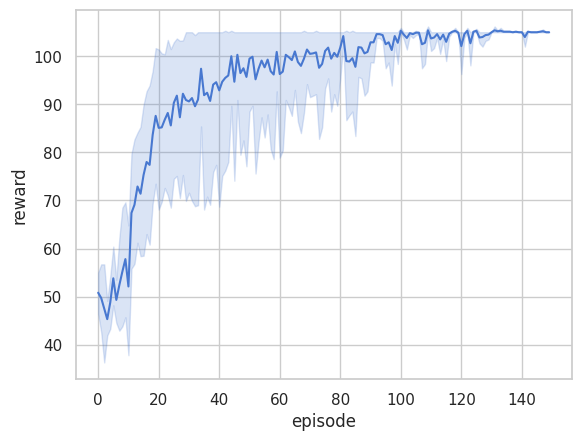

In [93]:
rewards_for_plot = [[reward for reward in rewards] for rewards in seed_rewards]
rewards_for_plot = pd.DataFrame(rewards_for_plot).melt()
rewards_for_plot.rename(columns={"variable": "episode", "value": "reward"}, inplace=True)
sns.set(style="whitegrid", palette="muted")
sns.lineplot(x="episode", y="reward", data=rewards_for_plot)
plt.show()